# Methylation Fraction Dependence

How much does methylation fraction affect linker length? To answer this question, at each of five chemical potentials, we ran linker length simulations for five different methylation fractions. For each combination of methylation fraction and chemical potential, we ran 20 replicates. In this notebook we compute the average "in-range" parameter, $\gamma$, from each simulation.

#### Specify Package Root Directory

In [1]:
import os
import sys

# Get the absolute path of the notebook's directory
notebook_directory = os.path.dirname(os.path.abspath('__file__'))

# Navigate one level up to get the root directory path
root_directory = os.path.abspath(os.path.join(notebook_directory, '..'))

# Change the working directory to the root directory
os.chdir(root_directory)

# Append the root directory to sys.path
sys.path.append(root_directory)

#### Import Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sliding_nucleosome.nucleo_arr as nuc

#### Characterize Simulations

In [3]:
# Specify the directory containing all simulations
out_dir = "/scratch/users/jwakim/sliding_nucleosome/output_var_methyl_frac"

# List simulations
sims = os.listdir(out_dir)
sims = [sim for sim in sims if sim.startswith("sim_") and os.path.isdir(os.path.join(out_dir, sim))]
sim_inds = [int(sim.split("_")[1]) for sim in sims]
sims = [sim for _, sim in sorted(zip(sim_inds, sims))]
sim_inds = np.sort(sim_inds)

# Simulations vary in methylation fraction and chemical potential
sim_paths = {}
latest_snap_paths = {}
sim_to_methyl_frac_mu = {}
methyl_frac_mu_to_sim = {}
all_methyl_frac_mu = set()

for i, sim in enumerate(sims):
    
    if (i+1) % 50 == 0:
        print(f"Sim {i+1} of {len(sims)}")

    # Identify the latest snapshot
    sim_path = os.path.join(out_dir, sim)
    sim_paths[sim] = sim_path
    snaps = os.listdir(sim_path)
    snaps = [snap for snap in snaps if snap.startswith("snap_") and snap.endswith(".json")]
    snaps = [snap for snap in snaps if snap != "snap_init.json"]
    snap_inds = [int(snap.split("_")[-1].split(".")[0]) for snap in snaps]
    last_snap = snaps[np.argmax(snap_inds)]
    snap_path = os.path.join(sim_path, last_snap)
    latest_snap_paths[sim] = snap_path
    
    # Load configuration
    nuc_arr = nuc.NucleosomeArray.load(snap_path)
    
    # Identify the chemical potential
    methyl_frac = np.average(nuc_arr.marks[:, 0])
    mu = nuc_arr.mu[0]
    
    # Generate a string representation of the methylation fraction and chemical potential
    methyl_frac_mu = f"{methyl_frac}_{mu}"
    sim_to_methyl_frac_mu[sim] = methyl_frac_mu
    
    # Store the chain length
    if methyl_frac_mu not in all_methyl_frac_mu:
        methyl_frac_mu_to_sim[methyl_frac_mu] = [sim]
        all_methyl_frac_mu.add(methyl_frac_mu)
    else:
        methyl_frac_mu_to_sim[methyl_frac_mu].append(sim)

Sim 50 of 479
Sim 100 of 479
Sim 150 of 479
Sim 200 of 479
Sim 250 of 479
Sim 300 of 479
Sim 350 of 479
Sim 400 of 479
Sim 450 of 479


#### Compute Average In-Range Parameter (Gamma)

In [4]:
all_methyl_frac_mu_lst = list(methyl_frac_mu_to_sim.keys())

In [5]:
all_avg_gamma = {}

for methyl_frac_mu in all_methyl_frac_mu_lst:
    
    methyl_frac = float(methyl_frac_mu.split("_")[0])
    all_avg_gamma[methyl_frac] = {}
    
    mu = float(methyl_frac_mu.split("_")[1])
    all_avg_gamma[methyl_frac][mu] = {}
    
    sims = methyl_frac_mu_to_sim[methyl_frac_mu]

    for sim in sims: 

        # Identify latest snapshot
        sim_path = sim_paths[sim]
        snap_path = latest_snap_paths[sim]

        # Load configuration
        nuc_arr = nuc.NucleosomeArray.load(snap_path)

        # Compute average gamma parameter
        all_avg_gamma[methyl_frac][mu][sim] = np.average(nuc_arr.gamma)

#### Plot Gamma vs. Methylation Fraction
For each chemical potential, we will plot how average gamma varies with methylation fraction.

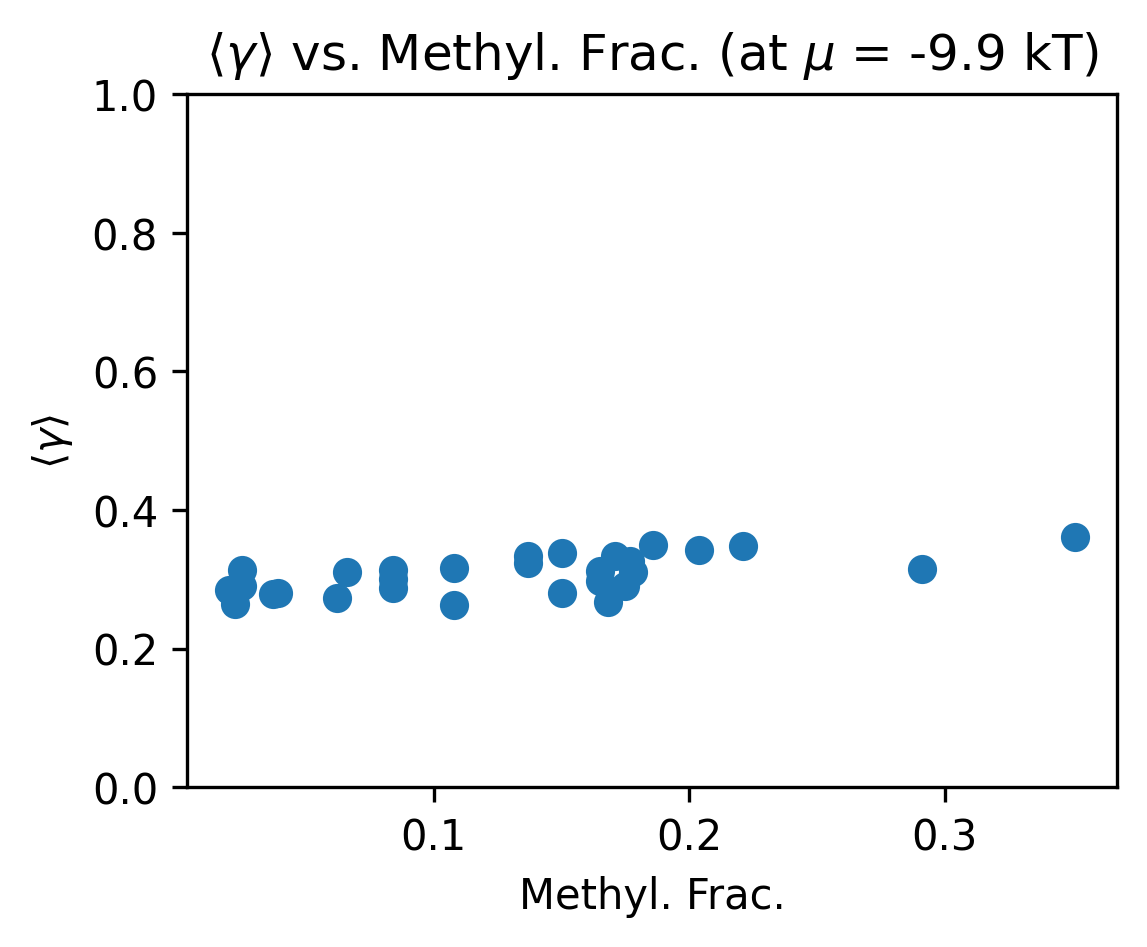

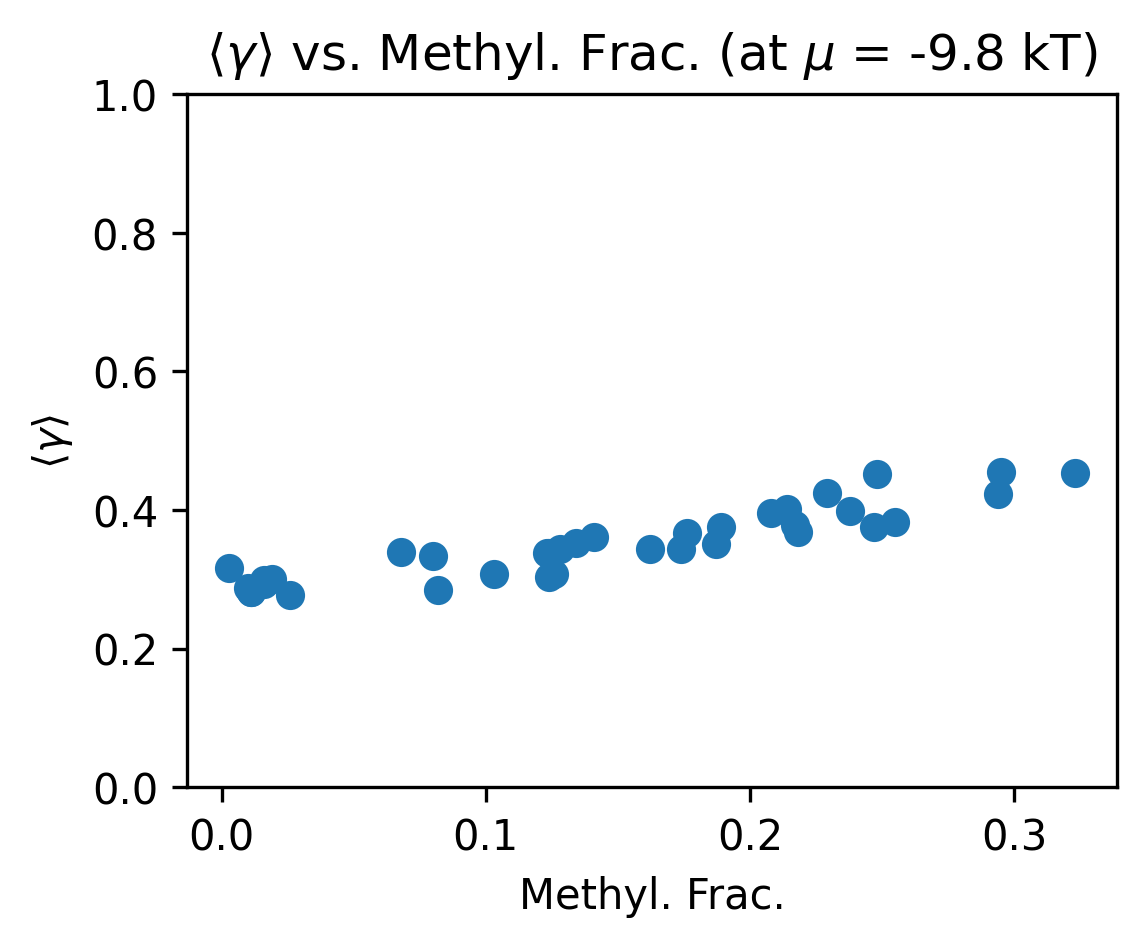

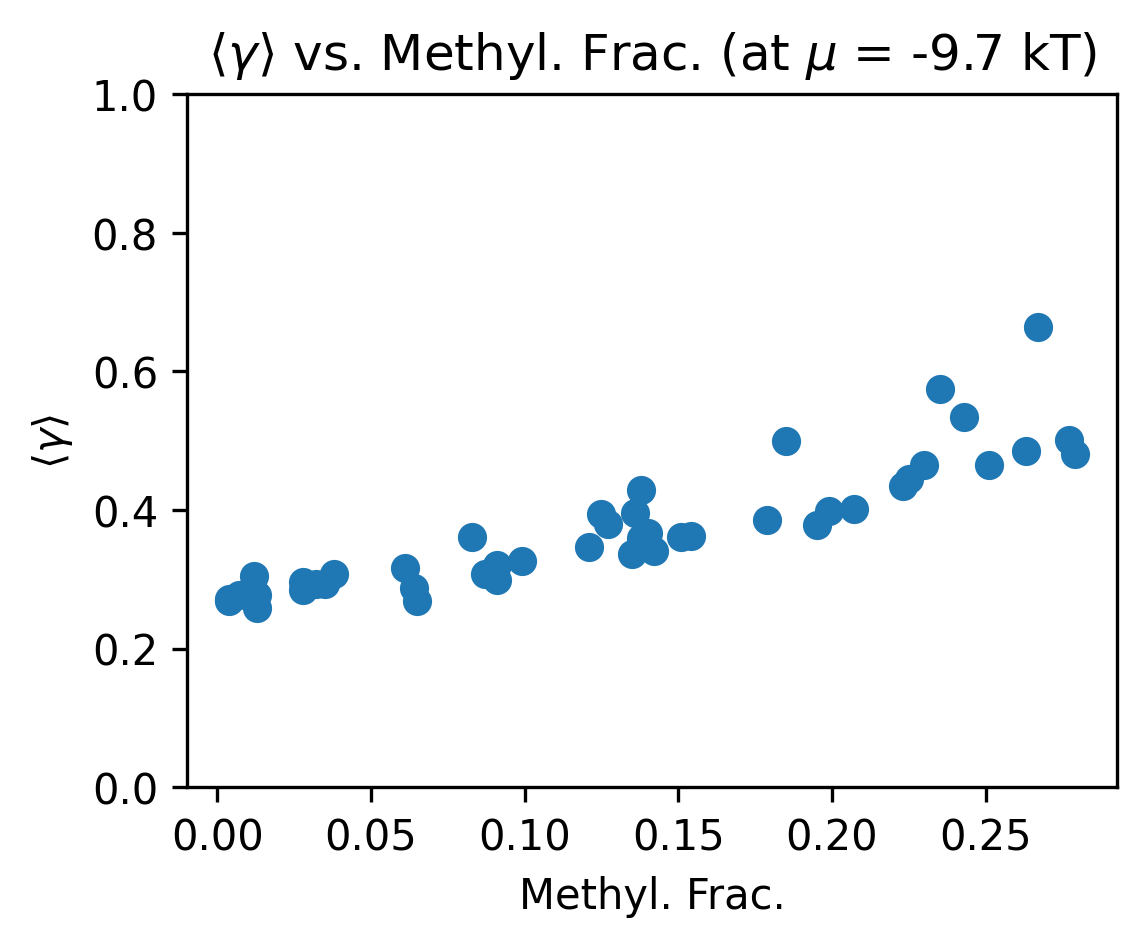

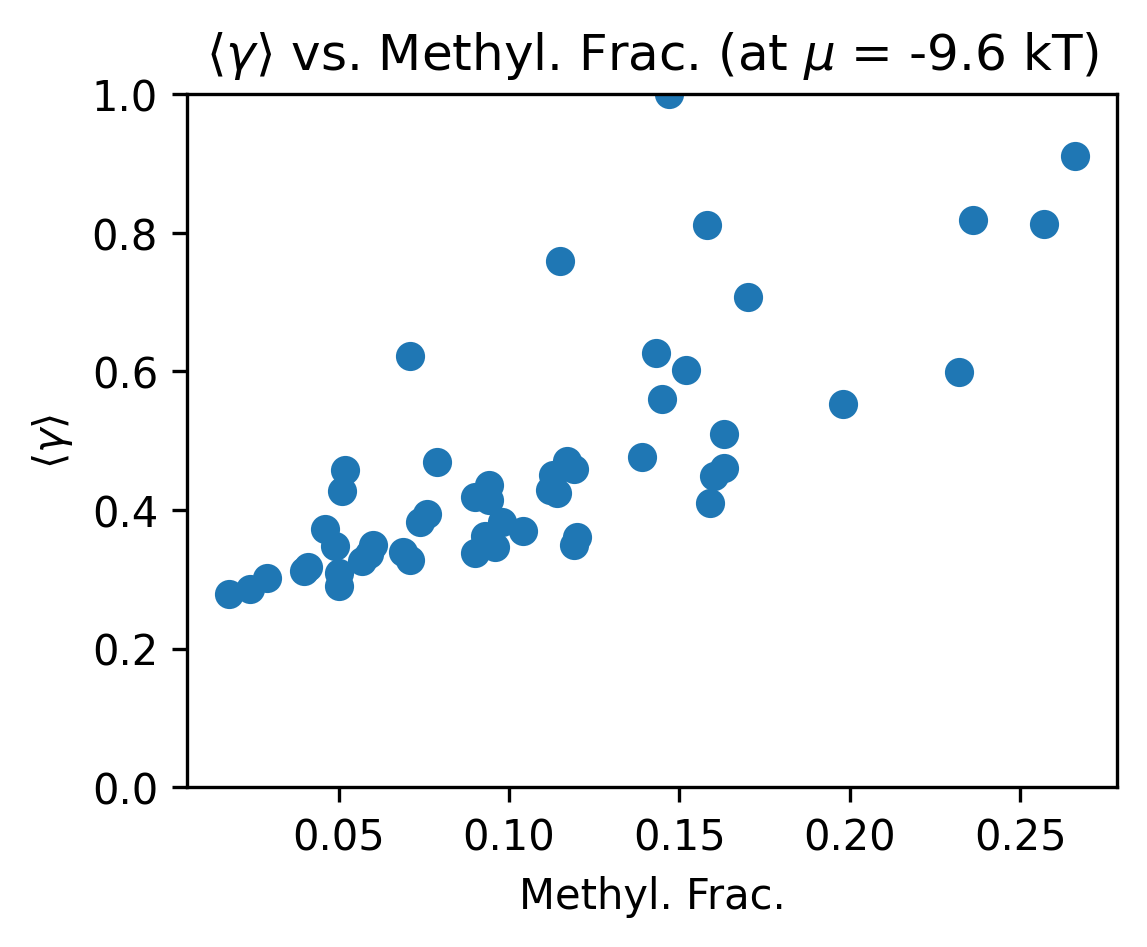

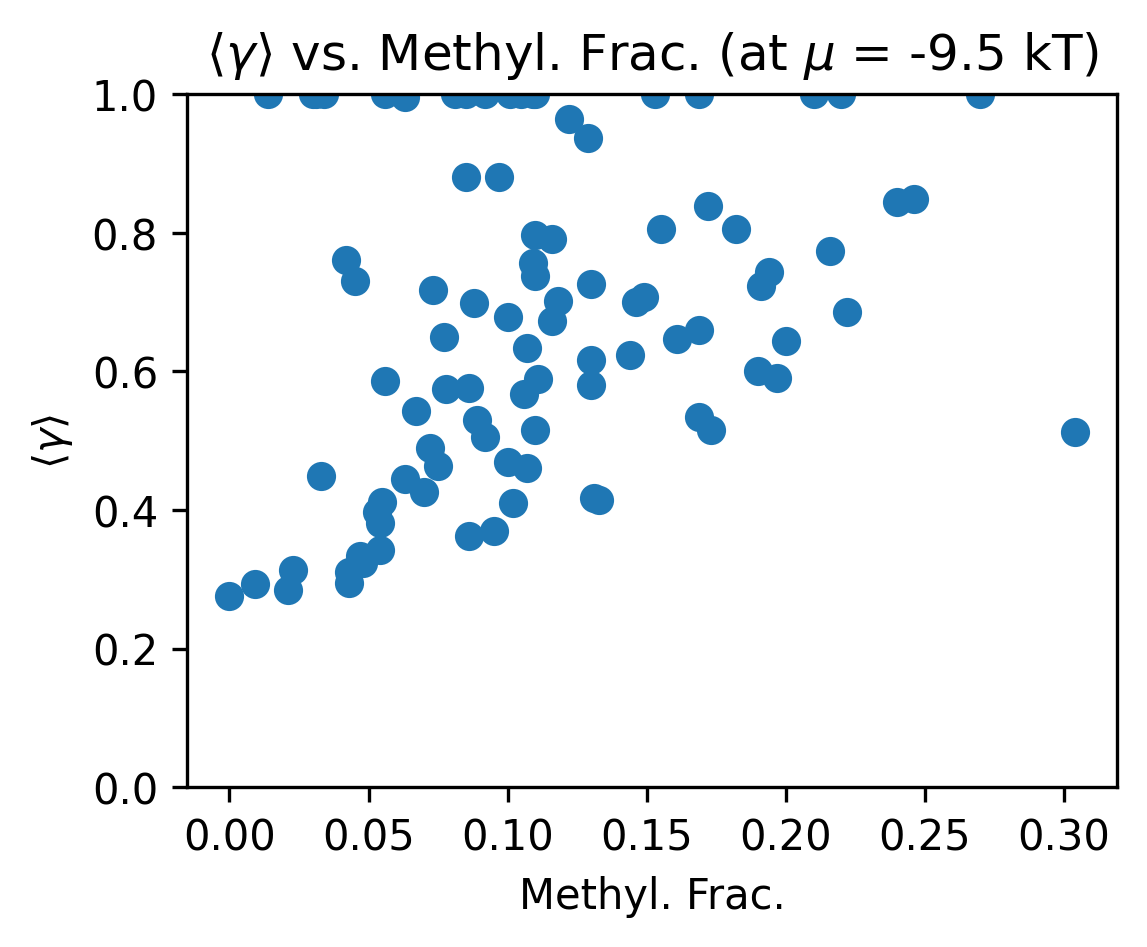

In [9]:
# Prepare data for plotting
methyl_frac_plot = []
mu_plot = []
avg_gamma_plot = []
for methyl_frac in all_avg_gamma.keys():
    for mu in all_avg_gamma[methyl_frac].keys():
        for sim in all_avg_gamma[methyl_frac][mu]:
            methyl_frac_plot.append(methyl_frac)
            mu_plot.append(mu)
            avg_gamma_plot.append(all_avg_gamma[methyl_frac][mu][sim])

# Covert to numpy arrays (for easier indexing)
methyl_frac_plot = np.array(methyl_frac_plot)
mu_plot = np.array(mu_plot)
avg_gamma_plot = np.array(avg_gamma_plot)
unique_mu = np.unique(mu_plot)

# For each chemical potential, plot average gamma vs methylation fraction
for mu in unique_mu:
    inds = (mu_plot == mu)
    plt.figure(figsize=(4, 3), dpi=300)
    plt.scatter(methyl_frac_plot[inds], avg_gamma_plot[inds])
    plt.xlabel(r"Methyl. Frac.")
    plt.ylabel(r"$\langle\gamma\rangle$")
    plt.ylim((0, 1))
    plt.title(fr"$\langle\gamma\rangle$ vs. Methyl. Frac. (at $\mu$ = {mu} kT)")
    plt.show()